<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#内置构建方法" data-toc-modified-id="内置构建方法-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>内置构建方法</a></span><ul class="toc-item"><li><span><a href="#读取libsvm格式数据" data-toc-modified-id="读取libsvm格式数据-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>读取libsvm格式数据</a></span></li><li><span><a href="#读取DataFrame格式数据" data-toc-modified-id="读取DataFrame格式数据-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>读取DataFrame格式数据</a></span></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>模型训练</a></span></li><li><span><a href="#交叉验证" data-toc-modified-id="交叉验证-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>交叉验证</a></span></li><li><span><a href="#使用预处理的交叉验证" data-toc-modified-id="使用预处理的交叉验证-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>使用预处理的交叉验证</a></span></li><li><span><a href="#自定义损失函数" data-toc-modified-id="自定义损失函数-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>自定义损失函数</a></span></li></ul></li><li><span><a href="#scikit-learn构建方法" data-toc-modified-id="scikit-learn构建方法-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>scikit-learn构建方法</a></span><ul class="toc-item"><li><span><a href="#模型训练" data-toc-modified-id="模型训练-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>模型训练</a></span></li><li><span><a href="#使用scikit-learn的交叉验证" data-toc-modified-id="使用scikit-learn的交叉验证-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>使用scikit-learn的交叉验证</a></span></li><li><span><a href="#网格搜索" data-toc-modified-id="网格搜索-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>网格搜索</a></span></li><li><span><a href="#训练过程评估验证集结果并加入early_stop" data-toc-modified-id="训练过程评估验证集结果并加入early_stop-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>训练过程评估验证集结果并加入early_stop</a></span></li><li><span><a href="#输出特征重要性" data-toc-modified-id="输出特征重要性-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>输出特征重要性</a></span></li></ul></li></ul></div>

In [2]:
import xgboost as xgb

In [23]:
import numpy as np

XGBOOST有两种构建方法，一种是内置的构建方法，一种是scikit-learn的构建方法。

# 内置构建方法

内置的构建方法就是XGBOOST提供的原生接口，它有两个特别的地方
+ 数据集读取使用内置的DMatrix接口，其支持多种数据格式(libsvm/numpy.array/scipy.sparse/pd.DataFrame/dt.Frame)
+ 模型的训练接口为train

## 读取libsvm格式数据

libsvm是一种通常用于存储稀疏数据的格式，只记录那些有值的列。文件中每一行为一个样本，第一列为标签，之后的每一列为`idx:value`格式，第一个数字表示列下标，第二个数值表示对应的取值。

```
0 1:1 9:1 19:1 21:1 24:1 34:1 36:1 39:1 
```

In [3]:
train_path = '../../../../Workspace/Datasets/agaricus/agaricus.txt.train'
test_path = '../../../../Workspace/Datasets/agaricus/agaricus.txt.test'
dtrain = xgb.DMatrix(train_path)
dtest = xgb.DMatrix(test_path)

[22:04:16] 6513x127 matrix with 143286 entries loaded from ../../../../Workspace/Datasets/agaricus/agaricus.txt.train
[22:04:16] 1611x127 matrix with 35442 entries loaded from ../../../../Workspace/Datasets/agaricus/agaricus.txt.test


## 读取DataFrame格式数据

In [4]:
import pandas as pd

In [6]:
data_dir = '../../../../Workspace/Datasets/pima-indians-diabetes.csv'
data_df = pd.read_csv(data_dir)

In [7]:
data_df.head()

,pregnants,Plasma_glucose_concentration,blood_pressure,Triceps_skin_fold_thickness,serum_insulin,BMI,Diabetes_pedigree_function,Age,Target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
features = ['pregnants', 'Plasma_glucose_concentration', 'blood_pressure', 'Triceps_skin_fold_thickness', 'serum_insulin', 'BMI', 'Diabetes_pedigree_function', 'Age']
labels = ['Target']

ddata = xgb.DMatrix(data_df[features], data_df[labels])

In [10]:
ddata.feature_names, ddata.feature_types

(['pregnants',
  'Plasma_glucose_concentration',
  'blood_pressure',
  'Triceps_skin_fold_thickness',
  'serum_insulin',
  'BMI',
  'Diabetes_pedigree_function',
  'Age'],
 ['int', 'int', 'int', 'int', 'int', 'float', 'float', 'int'])

## 模型训练

In [13]:
params = {'max_depth': 3,
          'colsample_bytree': 0.7,
          'objective':'binary:logistic'}

ntrees = 4

watchlist  = [(dtest,'eval'), (dtrain,'train')]

model = xgb.train(params, dtrain, ntrees, watchlist)

[0]	eval-error:0.022346	train-error:0.017811
[1]	eval-error:0.022346	train-error:0.017811
[2]	eval-error:0.019243	train-error:0.016122
[3]	eval-error:0.007449	train-error:0.006756


In [16]:
# 输出样本属于标签1的概率
y_pred_prob = model.predict(dtest)
y_pred_prob

array([0.14938417, 0.741777  , 0.14938417, ..., 0.8581995 , 0.14215484,
       0.8581995 ], dtype=float32)

In [25]:
# 计算错误率
y_true = dtest.get_label()

y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

print('错误率: {:.4f}'.format(np.sum(y_pred != y_true) / len(y_true)))

错误率: 0.0074


## 交叉验证

In [28]:
xgb.cv(params, dtrain, ntrees, nfold=10, stratified=True, metrics='error', seed=0)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.017810,0.000433,0.017811,0.003900
1,0.013904,0.002214,0.013972,0.004314
2,0.009554,0.006265,0.009519,0.006542
3,0.004794,0.003486,0.005067,0.004293


输出的结果是4棵树在10次训练中的平均错误率。

## 使用预处理的交叉验证

所谓的预处理，即在每折交叉验证之前使用定义的函数进行一些预处理操作，比如重新设置模型参数等。

In [30]:
# 根据训练集正负样本的比率，调整正样本权重
# 自定义预处理函数输入和输出都固定为dtrain, dtest, params
def adjust_sample_weight(dtrain, dtest, params):
    labels = dtrain.get_label()
    ratio = np.sum(labels==0) / np.sum(labels==1)
    params['scale_pos_weight'] = ratio
    return dtrain, dtest, params
    
xgb.cv(params, dtrain, ntrees, nfold=10, stratified=True, metrics='error', 
       fpreproc=adjust_sample_weight, seed=0)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.017810,0.000433,0.017811,0.003900
1,0.013665,0.001936,0.013665,0.003851
2,0.009690,0.006098,0.010133,0.005874
3,0.005374,0.003317,0.005682,0.004182


## 自定义损失函数

In [ ]:
print('使用自定义损失函数进行交叉验证')
# 自定义损失函数，需要提供损失函数的一阶导和二阶导
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0-preds)
    return grad, hess

# 自定义评估准则，评估预估值和标准答案之间的差距
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

watchlist  = [(dtest,'eval'), (dtrain,'train')]
param = {'max_depth':3, 'eta':0.1, 'silent':1}
num_round = 5
# 自定义损失函数训练
bst = xgb.train(param, dtrain, num_round, watchlist, logregobj, evalerror)
# 交叉验证
xgb.cv(param, dtrain, num_round, nfold = 5, seed = 0,
       obj = logregobj, feval=evalerror)

In [31]:
# 自定义损失函数的输入固定为模型预测的结果以及训练集
# 输出固定为一阶导数和二阶导数
def obj_logreg(preds, dtrain):
    labels = dtrain.get_label()
    y_pred = 1 / (1 + np.exp(-preds))
    # 计算一阶导数
    grad = y_pred - labels
    # 计算二阶导数
    hessian = y_pred * (1 - y_pred)
    return grad, hessian

In [36]:
# 自定义评估准则的输入固定为模型预测的结果以及训练集
# 输出固定为评估标准的名称和结果
def eval_acc(preds, dtrain):
    labels = dtrain.get_label()
    y_pred = [1 if p > 0.3 else 0 for p in preds]
    return 'my_acc', np.sum(y_pred == labels) / len(labels)

In [37]:
model = xgb.train(params, dtrain, ntrees, watchlist, obj=obj_logreg, feval=eval_acc)

[0]	eval-error:0.022346	train-error:0.017811	eval-my_acc:0.481688	train-my_acc:0.482113
[1]	eval-error:0.02545	train-error:0.019499	eval-my_acc:0.977654	train-my_acc:0.982189
[2]	eval-error:0.022346	train-error:0.017811	eval-my_acc:0.980757	train-my_acc:0.983878
[3]	eval-error:0.022346	train-error:0.017811	eval-my_acc:0.986344	train-my_acc:0.98741


# scikit-learn构建方法

所谓scikit-learn构建方法，其实是xgboost为了符合大家的使用习惯而封装的类似scikit-learn的接口。

## 模型训练

In [7]:
from xgboost import XGBClassifier

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data_dir = '../../../../Workspace/Datasets/pima-indians-diabetes.csv'
data_df = pd.read_csv(data_dir)

In [5]:
features = ['pregnants', 'Plasma_glucose_concentration', 'blood_pressure', 'Triceps_skin_fold_thickness', 'serum_insulin', 'BMI', 'Diabetes_pedigree_function', 'Age']
labels = ['Target']

X, y = data_df[features], data_df[labels]

In [19]:
type(X)

pandas.core.frame.DataFrame

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
clf = XGBClassifier(max_depth=3, n_estimators=5, colsample_bytree=0.7)

In [9]:
clf.fit(X_train, y_train)

/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
# scikilt-learn方式的构建方法predict直接返回的是样本的标签
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [12]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_test, y_pred)

0.7402597402597403

## 使用scikit-learn的交叉验证

In [15]:
from sklearn.model_selection import KFold

In [16]:
kfolds = KFold(n_splits=3, shuffle=True)

In [27]:
X_arr, y_arr = X.values, y.values

In [29]:
for train_idx, test_idx in kfolds.split(X):
    clf = XGBClassifier(max_depth=3, n_estimators=5, colsample_bytree=0.7)
    clf.fit(X_arr[train_idx], y_arr[train_idx])
    y_pred = clf.predict(X_arr[test_idx])
    print('acc = {:.6f}'.format(accuracy_score(y_arr[test_idx], y_pred)))

acc = 0.734375
acc = 0.734375
acc = 0.746094


## 网格搜索

下面以学习率为例，通过网格搜索的方法寻找最优参数。

In [31]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [33]:
import time

In [34]:
model = XGBClassifier()
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param = dict(learning_rate=learning_rates)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=int(time.time()))
grid_search = GridSearchCV(model, param_grid=param, scoring="neg_log_loss", cv=kfold)
ret = grid_search.fit(X, y)

/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [35]:
# 获取最优参数和对应的结果
ret.best_score_, ret.best_params_

(-0.48622502657114336, {'learning_rate': 0.1})

In [36]:
# 获取每个参数在10折测试中对应结果的均值和方
means = ret.cv_results_["mean_test_score"]
stds = ret.cv_results_["std_test_score"]
params = ret.cv_results_["params"]
for mean, std, param in zip(means, stds, params):
    print(mean, std, param)

-0.6898936137246588 0.0006953680990315359 {'learning_rate': 0.0001}
-0.6627796068787575 0.006639290475743551 {'learning_rate': 0.001}
-0.5322255388794778 0.03959321726326683 {'learning_rate': 0.01}
-0.48622502657114336 0.08476413197610523 {'learning_rate': 0.1}
-0.5272211713310829 0.10212102563828929 {'learning_rate': 0.2}
-0.5789783422809099 0.11873666351673275 {'learning_rate': 0.3}


## 训练过程评估验证集结果并加入early_stop

In [37]:
eval_set = [(X_test, y_test)]
model = XGBClassifier()
# 指定early_stopping_rounds让模型可以提前停止训练
# 这个参数要求模型在early_stopping_rounds这么多次训练中的error值都要不断下降
model.fit(X_train, y_train, eval_set=eval_set, eval_metric="logloss", early_stopping_rounds=5)

[0]	validation_0-logloss:0.662467
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.633874
[2]	validation_0-logloss:0.613607
[3]	validation_0-logloss:0.594883
[4]	validation_0-logloss:0.578943
[5]	validation_0-logloss:0.565139
[6]	validation_0-logloss:0.553667
[7]	validation_0-logloss:0.54401
[8]	validation_0-logloss:0.535069
[9]	validation_0-logloss:0.525981
[10]	validation_0-logloss:0.519711
[11]	validation_0-logloss:0.511848
[12]	validation_0-logloss:0.505064
[13]	validation_0-logloss:0.499508
[14]	validation_0-logloss:0.495237
[15]	validation_0-logloss:0.493228
[16]	validation_0-logloss:0.489661
[17]	validation_0-logloss:0.486899
[18]	validation_0-logloss:0.484595
[19]	validation_0-logloss:0.483928
[20]	validation_0-logloss:0.47991
[21]	validation_0-logloss:0.478325
[22]	validation_0-logloss:0.475532
[23]	validation_0-logloss:0.473879
[24]	validation_0-logloss:0.471619
[25]	validation_0-logloss:0.472017
[26]	validation_0-logloss:0.472065


/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yangqj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

可以看到当模型发现logloss值不下降之后，就会提前停止训练，并且输出最优的结果。

## 输出特征重要性

In [38]:
from xgboost import plot_importance

In [39]:
%matplotlib inline

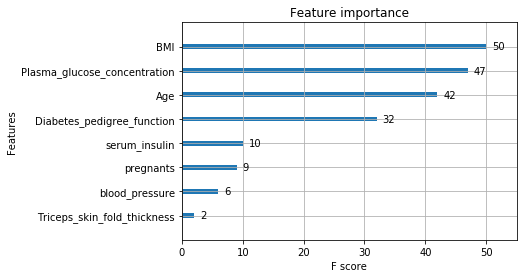

In [40]:
plot_importance(model)